# Byggingagreining á gervitunglamyndum
Nathan HK

In [2]:
from io import BytesIO
import math
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pyrosm import OSM
from pyrosm import get_data
import pywikibot
from selenium.common.exceptions import NoSuchElementException
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from shapely.geometry import Point
import sklearn as sk
from sklearn.model_selection import train_test_split
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
mappa = '/Users/002-nathan/Desktop/Envalys/gtm/'
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

## Inngangsorð
Við viljum þjálfa gervigreindarlíkan til að greina byggingar á gervitunglamyndum. Við þurfum tvenn gögn: gervitunglamyndir og staðsetningar bygginga.
- **Gervitunglamyndir:** Við notum skjámyndatökur af Já.is. Ég veit ekki hvort þetta sé löglegt, en ég er ekki með neinar betri leiðir.
- **Staðsetningar bygginga:** Við notum OpenStreetMap.

Ég nota Apple M1 Pro-örgjörvi með 16 GB minni.

## Gervitunglamyndir
Við notum lista yfir greinar á ensku Wikipediunni um staði á Höfuðborgarsvæðinu og Akureyri. Gögnin á Landsbyggðinni eru ekki nóg nákvæm fyrir þetta líkan.

In [4]:
byrjun = time.time()
hnitlisti = []
wiki = pywikibot.Site('en', 'wikipedia')

# Capital Region
flokkur_h = pywikibot.Category(wiki, 'Populated places in Capital Region (Iceland)')
undir = list(flokkur_h.subcategories(recurse=3))
buinn_fl = []  # Completed categories
buinn_si = []  # Completed pages
print(len(undir))
for a in undir:
    if a in buinn_fl:  # Already did category
        continue
    for b in a.articles():
        if b in buinn_si:  # Already did page
            continue
        coord = b.coordinates(primary_only=True)
        # Coordinates are invalid outside latitude [63, 67] and longitude [-25, -12]
        if coord is not None and coord.lat >= 63 and coord.lat <= 67 and coord.lon >= -25 and coord.lon <= -12:
            hnitlisti.append(('h', float(coord.lat), float(coord.lon)))
        buinn_si.append(b)
    buinn_fl.append(a)
print('h', len(hnitlisti), time.time() - byrjun)

# Akureyri
flokkur_a = pywikibot.Category(wiki, 'Akureyri')
undir = list(flokkur_a.subcategories(recurse=3))
buinn_fl = []  # Completed categories
buinn_si = []  # Completed pages
print(len(undir))
for a in undir:
    if a in buinn_fl:  # Already did category
        continue
    for b in a.articles():
        if b in buinn_si:  # Already did page
            continue
        coord = b.coordinates(primary_only=True)
        # Coordinates are invalid outside latitude [63, 67] and longitude [-25, -12]
        if coord is not None and coord.lat >= 63 and coord.lat <= 67 and coord.lon >= -25 and coord.lon <= -12:
            hnitlisti.append(('a', float(coord.lat), float(coord.lon)))
        buinn_si.append(b)
    buinn_fl.append(a)
print('a', len(hnitlisti), time.time() - byrjun)

# Demo
hnitlisti.append(('d', 64.132737, -21.886075))

54
h 120 97.02059483528137
6
a 130 111.89431595802307


Við getum ekki tekið myndir af miðjunni skjásins, því það eru önnur HTML-efni sem hylja gervitunglamyndirnar. Þess vegna leitum við að staði sem eru 0.002° til austurs frá myndatökustaðnum; hérna eru hnitin á skjánum fyrir þennan stað.

In [5]:
skhn = (746, 861)

Við tökum skjámyndir af öllum stöðum á hnitlistanum.
- URL-ið notar ISN93-hnit, en okkar hnit eru WGS84, og það er engin einföld leið til að skipta milli þeirra. Þess vegna þurfum við að leita að hnitum eins og manneskja myndi leita.
- Á Chrome er myndasvæðið 512x512, en þegar myndin er vistuð verður hún 1024x1024.

In [6]:
byrjun = time.time()
driver = webdriver.Chrome()
driver.set_window_size(1500, 1000)
driver.get('https://ja.is/kort/?x=356954&y=408253&nz=17.00&type=aerialnl')
# Accept GDPR
try:
    btn = driver.find_element(By.XPATH, '//a[@id="gdpr_banner_ok"]')
    btn.click()
except NoSuchElementException:
    pass
# Allow cookies
try:
    btn = driver.find_element(By.XPATH, '//button[@class="ch2-btn ch2-allow-all-btn ch2-btn-primary"]')
    btn.click()
except NoSuchElementException:
    pass
leit = driver.find_element(By.XPATH, '//input[@id="mapq"]')
for n in range(len(hnitlisti)):
    if n % 50 == 0:
        print(n, time.time() - byrjun)
    hnit = hnitlisti[n]
    # Input search term into search box
    try:
        z = open(mappa + hnit[0] + '_' + str(hnit[1]) + '_' + str(hnit[2]) + '.png', 'rb')
        z.close()
    except FileNotFoundError:
        leit.clear()
        leit.send_keys(str(hnit[1]) + ', ' + str(hnit[2] + 0.002))
        leit.send_keys(Keys.RETURN)
        time.sleep(2) # Wait for images to load
        try:  # Place not found
            nf = driver.find_element(By.XPATH, '//div[@class="row not-found"]')
        except NoSuchElementException:  # Place found, save and crop screenshot
            driver.save_screenshot(mappa + hnit[0] + '_' + str(hnit[1]) + '_' + str(hnit[2]) + '.png')
            skmynd = Image.open(mappa + hnit[0] + '_' + str(hnit[1]) + '_' + str(hnit[2]) + '.png')
            skmynd = skmynd.crop((skhn[0] - 512, skhn[1] - 512, skhn[0] + 512, skhn[1] + 512))
            skmynd.save(mappa + hnit[0] + '_' + str(hnit[1]) + '_' + str(hnit[2]) + '.png')
        time.sleep(1)
driver.close()
print(time.time() - byrjun)

0 4.65667724609375
50 4.66021990776062
100 4.663288116455078
4.791000127792358


## Staðsetningar bygginga
Við sækjum gögn frá OpenStreetMap.

In [7]:
fp = get_data('Iceland')

Þetta undirforrit tekur díl á myndinni og finnur GPS-hnitin. Við notum Web Mercator.

In [8]:
def pix2coord(pix, hnit_br):
    x_t = hnit_br[1] + (pix[0] - 512) / 1024
    lon = math.degrees(x_t * 2 * math.pi / (2 ** 17) - math.pi)
    y_t = hnit_br[0] + (pix[1] - 512) / 1024
    lat = math.degrees(2 * (math.atan(math.exp(math.pi - y_t * 2 * math.pi / (2 ** 17))) - math.pi / 4))
    return (lat, lon)

Þetta undirforrit tekur GPS-hnit og finnur dílinn á myndinni. Forritað með aðstoð frá o1-preview eftir OpenAI.

In [9]:
def coord2pix(lat, lon, hnit_br):
    # Convert degrees to radians
    lon_radians = math.radians(lon)
    lat_radians = math.radians(lat)
    
    # Invert the calculation for x_t
    x_t = ((lon_radians + math.pi) * (2 ** 17)) / (2 * math.pi)
    # Calculate pix[0] (x-coordinate)
    pix_x = (x_t - hnit_br[1]) * 1024 + 512
    
    # Invert the calculation for y_t
    b = lat_radians / 2 + math.pi / 4
    a = math.tan(b)
    c = math.pi - math.log(a)
    y_t = c * (2 ** 17) / (2 * math.pi)
    # Calculate pix[1] (y-coordinate)
    pix_y = (y_t - hnit_br[0]) * 1024 + 512
    
    return (pix_x, pix_y)

Við sækjum tvo lista: einn yfir byggingar á Höfuðborgarsvæðinu, og einn á Akureyri.

In [10]:
byrjun = time.time()
byg_listi = {}
osm_h = OSM(fp, bounding_box=[-22.140901, 63.847886, -21.152576, 64.390306])
byg_listi['h'] = osm_h.get_buildings()
osm_a = OSM(fp, bounding_box=[-18.398071, 65.543087, -17.968359, 66.576398])
byg_listi['a'] = osm_a.get_buildings()
print(time.time() - byrjun)

25.638773918151855


Við deilum myndinni í 8x8 ílát. Fyrir hvert ílát útreiknum við hlutfall díla þar sem byggingar eru til.

In [39]:
ilat_fj = 16

In [40]:
byrjun = time.time()
X_gogn = []
y_gogn = []
bd_all = {}
for st in ['h', 'a']:
    byggingar = byg_listi[st]
    bd = []
    for k in range(byggingar.shape[0]):
        bns = byggingar['geometry'][k].bounds
        bd.append(bns)
    bd_all[st] = bd
for n in range(len(hnitlisti)):
    if n % 10 == 0:
        print(n, time.time() - byrjun)
    hnit = hnitlisti[n]
    # Open image
    try:
        gtm = Image.open(mappa + hnit[0] + '_' + str(hnit[1]) + '_' + str(hnit[2]) + '.png')
        dilar = gtm.load()
    except FileNotFoundError:
        continue
    if hnit[0] != 'd':
        X_gogn.append(torch.tensor(np.transpose(np.array(gtm.getdata()).reshape(1024, 1024, 3), 
                                                (2, 0, 1)).reshape(1, 3, 1024, 1024), dtype=torch.float32).to(device))
    # Convert coordinates
    y_n = 1 / (2 * math.pi) * 2 ** 17 * (math.pi - math.log(math.tan(math.pi / 4 + math.radians(hnit[1]) / 2))) - 0.5
    y_s = 1 / (2 * math.pi) * 2 ** 17 * (math.pi - math.log(math.tan(math.pi / 4 + math.radians(hnit[1]) / 2))) + 0.5
    if hnit[0] == 'd':
        byggingar = byg_listi['h']
    else:
        byggingar = byg_listi[hnit[0]]
    hnit_br = (1 / (2 * math.pi) * 2 ** 17 * (math.pi - math.log(math.tan(math.pi / 4 + math.radians(hnit[1]) / 2))),
               1 / (2 * math.pi) * 2 ** 17 * (math.pi + math.radians(hnit[2])))
    # Buildings
    y_mynd = np.zeros((1, 1, 1024, 1024))
    if hnit[0] == 'd':
        bd = bd_all['h']
    else:
        bd = bd_all[hnit[0]]
    for k in range(byggingar.shape[0]):
        bns = bd[k]
        if bns[0] > hnit[2] + 0.0014 or bns[1] > hnit[1] + 0.0008 or bns[2] < hnit[2] - 0.0014 or bns[3] < hnit[1] - 0.0008:
            continue
        NW = coord2pix(bns[3], bns[0], hnit_br)
        SE = coord2pix(bns[1], bns[2], hnit_br)
        if NW[0] > 1024 or NW[1] > 1024 or SE[0] < 0 or SE[1] < 0:
            continue
        for i in range(max(0, int(NW[0])), min(1024, int(SE[0]) + 1)):
            for j in range(max(0, int(NW[1])), min(1024, int(SE[1]) + 1)):
                if y_mynd[0][0][i][j] == 1:
                    continue
                coord = pix2coord((i, j), hnit_br)
                if byggingar['geometry'][k].contains(Point(coord[1], coord[0])):
                    y_mynd[0][0][i][j] = 1
    y_ilat = np.zeros((1, 1, ilat_fj, ilat_fj))
    for i in range(ilat_fj):
        for j in range(ilat_fj):
            y_ilat[0][0][i][j] = np.sum(y_mynd[0, 0, (1024//ilat_fj)*i:(1024//ilat_fj)*(i+1), 
                                        (1024//ilat_fj)*j:(1024//ilat_fj)*(j+1)]) / ((1024//ilat_fj) ** 2)
            for p in range((1024//ilat_fj)*i, (1024//ilat_fj)*(i+1)):
                for q in range((1024//ilat_fj)*j, (1024//ilat_fj)*(j+1)):
                    gtm.putpixel((p, q), (min(int(dilar[p,q][0] + 256 * (y_ilat[0][0][i][j])), 255), dilar[p,q][1], dilar[p,q][2]))
    gtm.save(mappa + 'saman_' + hnit[0] + '_' + str(hnit[1]) + '_' + str(hnit[2]) + '.png')
    if hnit[0] != 'd':
        y_gogn.append(torch.tensor(y_ilat, dtype=torch.float32).to(device))
print(time.time() - byrjun)

0 0.5265600681304932
10 89.6754219532013
20 175.44434309005737
30 282.78260827064514
40 419.40495014190674
50 500.17438530921936
60 591.0214562416077
70 652.6264209747314
80 709.9565570354462
90 833.1217510700226
100 989.6628999710083
110 1070.9071810245514
120 1176.3673360347748
130 1239.6163771152496
1246.0539300441742


In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_gogn, y_gogn)

## Líkan
Hérna er CNN til að greina díla á gervitunglamyndum. Forritað með aðstoð frá o1-preview.

In [42]:
def custom_loss_function(predictions, targets, alpha=1.0, beta=0.1, gamma=0.1):
    mse_loss = F.mse_loss(predictions, targets)
    
    # Total Variation Loss
    tv_loss = torch.mean(torch.abs(predictions[:, :, 1:, :] - predictions[:, :, :-1, :])) + \
              torch.mean(torch.abs(predictions[:, :, :, 1:] - predictions[:, :, :, :-1]))
    
    # Edge-aware Loss using Sobel Filters
    sobel_kernel_x = torch.tensor([[1, 0, -1],
                                   [2, 0, -2],
                                   [1, 0, -1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    sobel_kernel_y = torch.tensor([[1, 2, 1],
                                   [0, 0, 0],
                                   [-1, -2, -1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    
    grad_x = F.conv2d(predictions, sobel_kernel_x, padding=1)
    grad_y = F.conv2d(predictions, sobel_kernel_y, padding=1)
    edge_loss = torch.mean(torch.sqrt(grad_x ** 2 + grad_y ** 2))
    
    # Combine the losses
    loss = alpha * mse_loss# + beta * tv_loss + gamma * edge_loss
    return loss

In [43]:
class BuildingOccupancyModel(nn.Module):
    def __init__(self):
        super(BuildingOccupancyModel, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        
        self.layer6 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        
        self.layer7 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        
        self.output_layer = nn.Sequential(
            nn.Conv2d(512, 1, kernel_size=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.layer1(x)  # Output: [batch_size, 64, 512, 512]
        x = self.layer2(x)  # Output: [batch_size, 128, 256, 256]
        x = self.layer3(x)  # Output: [batch_size, 256, 128, 128]
        x = self.layer4(x)  # Output: [batch_size, 512, 64, 64]
        x = self.layer5(x)  # Output: [batch_size, 512, 32, 32]
        if ilat_fj <= 16:
            x = self.layer6(x)  # Output: [batch_size, 512, 16, 16]
        if ilat_fj <= 8:
            x = self.layer7(x)  # Output: [batch_size, 512, 8, 8]
        x = self.output_layer(x)  # Output: [batch_size, 1, 8, 8]
        return x

In [44]:
epochs = 10

In [45]:
byrjun = time.time()
likan = BuildingOccupancyModel()
likan = likan.to(device)
optimizer = torch.optim.Adam(likan.parameters(), lr=1e-4, weight_decay=1e-5)
train_loss = []
test_loss = []
for e in range(epochs):
    likan.eval()
    with torch.no_grad():
        running_loss = 0.0
        for i in range(len(X_train)):
            images = X_train[i]
            targets = y_train[i]
            y_pred = likan(images)
            loss = custom_loss_function(y_pred, targets)
            running_loss += loss
        train_loss.append((running_loss / len(X_train)).item())
        running_loss = 0.0
        for i in range(len(X_test)):
            images = X_test[i]
            targets = y_test[i]
            y_pred = likan(images)
            loss = custom_loss_function(y_pred, targets)
            running_loss += loss
        test_loss.append((running_loss / len(X_test)).item())
        
    likan.train()
    running_loss = 0.0
    for i in range(len(X_train)):
        images = X_train[i]
        targets = y_train[i]
        
        optimizer.zero_grad()
        y_pred = likan(images)
        
        loss = custom_loss_function(y_pred, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(X_train)
    print(f"Epoch [{e+1}/{epochs}], Loss: {avg_loss:.4f}, Time: {time.time() - byrjun}")

likan.eval()
with torch.no_grad():
    running_loss = 0.0
    for i in range(len(X_train)):
        images = X_train[i]
        targets = y_train[i]
        y_pred = likan(images)
        loss = custom_loss_function(y_pred, targets)
        running_loss += loss
    train_loss.append((running_loss / len(X_train)).item())
    running_loss = 0.0
    for i in range(len(X_test)):
        images = X_test[i]
        targets = y_test[i]
        y_pred = likan(images)
        loss = custom_loss_function(y_pred, targets)
        running_loss += loss
    test_loss.append((running_loss / len(X_test)).item())

Epoch [1/10], Loss: 0.1549, Time: 30.973787784576416
Epoch [2/10], Loss: 0.1205, Time: 60.89931273460388
Epoch [3/10], Loss: 0.1163, Time: 91.64665699005127
Epoch [4/10], Loss: 0.1154, Time: 121.5330708026886
Epoch [5/10], Loss: 0.1148, Time: 151.49281096458435
Epoch [6/10], Loss: 0.1092, Time: 181.38489484786987
Epoch [7/10], Loss: 0.1050, Time: 211.24643468856812
Epoch [8/10], Loss: 0.1013, Time: 241.1272497177124
Epoch [9/10], Loss: 0.0909, Time: 271.0748658180237
Epoch [10/10], Loss: 0.0794, Time: 301.0676836967468


## Mat

Train loss: 0.10983521491289139
Test loss: 0.12454713135957718


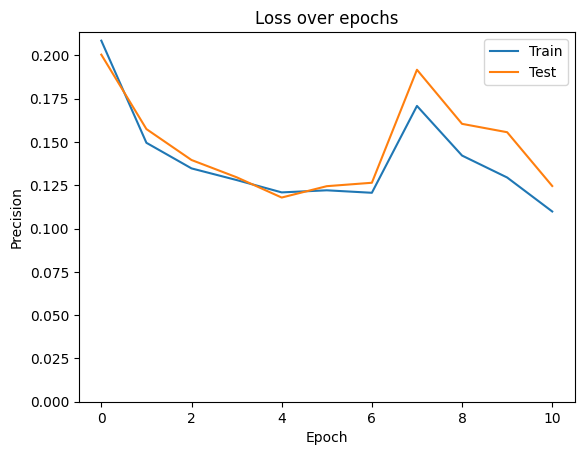

In [46]:
print('Train loss:', train_loss[-1])
print('Test loss:', test_loss[-1])
plt.plot(train_loss, label='Train')
plt.plot(test_loss, label='Test')
plt.ylim(bottom=0)
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.show()

Hérna eru tvær myndir: vinstri myndin sýnir eiginleg gögn, og hægri myndin sýnir spáina frá líkaninu.

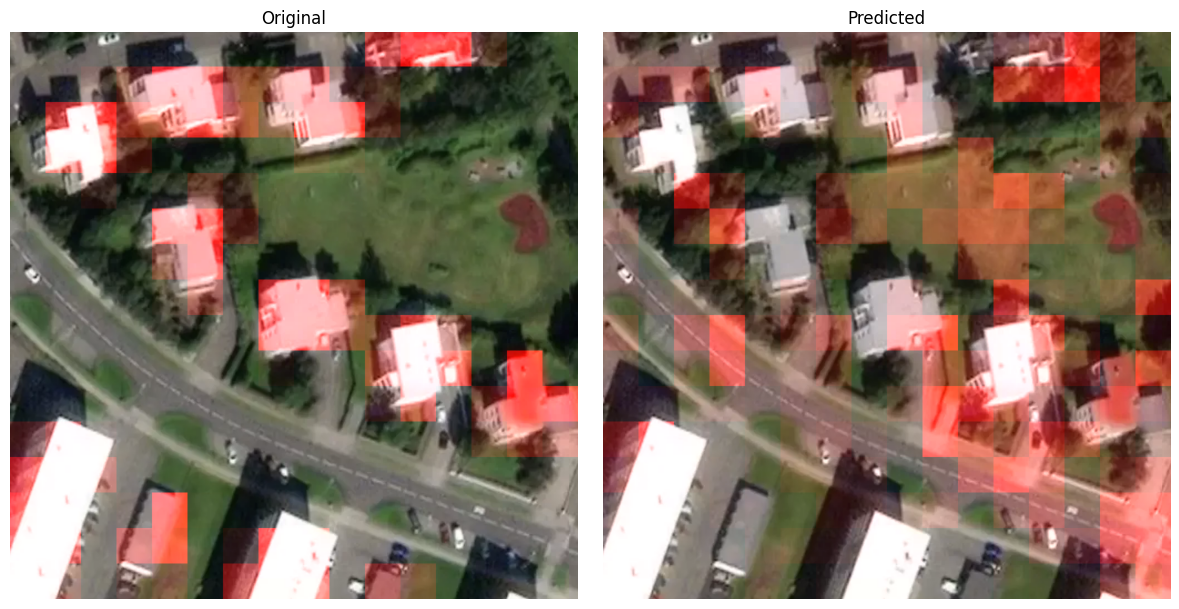

In [50]:
gtm = Image.open(mappa + 'd_64.132737_-21.886075.png')
dilar = gtm.load()
X_mynd = torch.tensor(np.transpose(np.array(gtm.getdata()).reshape(1024, 1024, 3),
                                   (2, 0, 1)).reshape(1, 3, 1024, 1024), dtype=torch.float32).to(device)
likan.eval()
with torch.no_grad():
    y_pred = likan(X_mynd)
    y_pred = y_pred.cpu().numpy()
for i in range(ilat_fj):
    for j in range(ilat_fj):
        for p in range((1024//ilat_fj)*i, (1024//ilat_fj)*(i+1)):
            for q in range((1024//ilat_fj)*j, (1024//ilat_fj)*(j+1)):
                gtm.putpixel((p, q), (min(int(dilar[p,q][0] + 256 * (y_pred[0][0][i][j])), 255), dilar[p,q][1], dilar[p,q][2]))
gtm.save(mappa + 'nst_d_64.132737_-21.886075.png')
img1 = mpimg.imread(mappa + 'saman_d_64.132737_-21.886075.png')
img2 = mpimg.imread(mappa + 'nst_d_64.132737_-21.886075.png')
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img1)
axes[0].axis('off')
axes[0].set_title('Original')
axes[1].imshow(img2)
axes[1].axis('off')
axes[1].set_title('Predicted')
plt.tight_layout()
plt.show()

## Lokaorð
Greiningin gekk illa. Líkanið er alls ekki nógu nákvæmt fyrir eiginlega notkun.

Hvert förum við héðan?
- Við notum fleiri og smærri ílát.
- Við fáum fleiri gervitunglamyndir.
- Við fáum betri gervitunglamyndir. Á þeim sem við notum núna eru byggingarnar hallaðar, og hnitin eru oft ekki nógu nákvæm.